# Setup Working directory

In [ ]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("../")

# Download Dependencies

## Install Libraries

In [1]:
!pip install -q transformers datasets pandas underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 84.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.4 MB/s eta 0:00:00


## Download Dataset

In [2]:
!git clone https://github.com/triet2397/UIT-ViCoV19QA

Cloning into 'UIT-ViCoV19QA'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 81 (delta 26), reused 54 (delta 15), pack-reused 0 (from 0)
Receiving objects: 100% (81/81), 1.75 MiB | 12.87 MiB/s, done.
Resolving deltas: 100% (26/26), done.


In [3]:
import os
import shutil

os.makedirs("dataset", exist_ok=True)
shutil.copytree("UIT-ViCoV19QA/dataset", "dataset", dirs_exist_ok=True)

'dataset'

# Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.model_selection import train_test_split
import re, string
from gensim.models import KeyedVectors
from collections import Counter
from underthesea import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import preprocessing, utils, activations
# from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

# Data Processing

## Pre-Processing

In [5]:
def melt_dataframe_and_drop_na(_df):
  # Melt the DataFrame
  melted_df = pd.melt(_df, id_vars=['id', 'Question'], value_vars=['Answer_1', 'Answer_2', 'Answer_3', 'Answer_4'],
                      var_name='Answer_Number', value_name='Answer')
  # Remove the 'Answer_' prefix from the Answer_Number column
  melted_df['Answer_Number'] = melted_df['Answer_Number'].str.replace('Answer_', '')
  # Reorder the columns to match the desired format
  melted_df = melted_df[['id', 'Question', 'Answer']]
  # Replace columns name
  melted_df = melted_df.rename(columns={'Question': 'question', 'Answer': 'answer'})
  melted_df = melted_df.drop(columns=['id'])
  # Drop NaN values
  melted_df = melted_df.dropna()
  # Drop duplicate rows
  melted_df = melted_df.drop_duplicates()

  return melted_df

In [6]:
df = pd.read_csv('dataset/UIT-ViCoV19QA.csv', sep='|')
df = melt_dataframe_and_drop_na(df)
df.head()

,question,answer
0,Tại sao bệnh này lại được gọi là bệnh vi-rút c...,"Vào ngày 11 tháng 2 năm 2020, Tổ Chức Y Tế Thế..."
1,Vi-rút lây lan như thế nào?,COVID-19 được cho là lây lan chủ yếu thông qua...
2,Lây lan trong cộng đồng là gì?,Lây lan trong cộng đồng nghĩa là mọi người bị ...
3,Muỗi hay ve có thể truyền vi-rút gây bệnh COVI...,"Tại thời điểm này, CDC không có dữ liệu nào ch..."
4,Làm thế nào tôi có thể tự bảo vệ bản thân khỏi...,Truy cập trang Cách Bảo Vệ Bản Thân Và Người K...


In [7]:
data = df.values
questions = data[:, 0]
answers = data[:, 1]

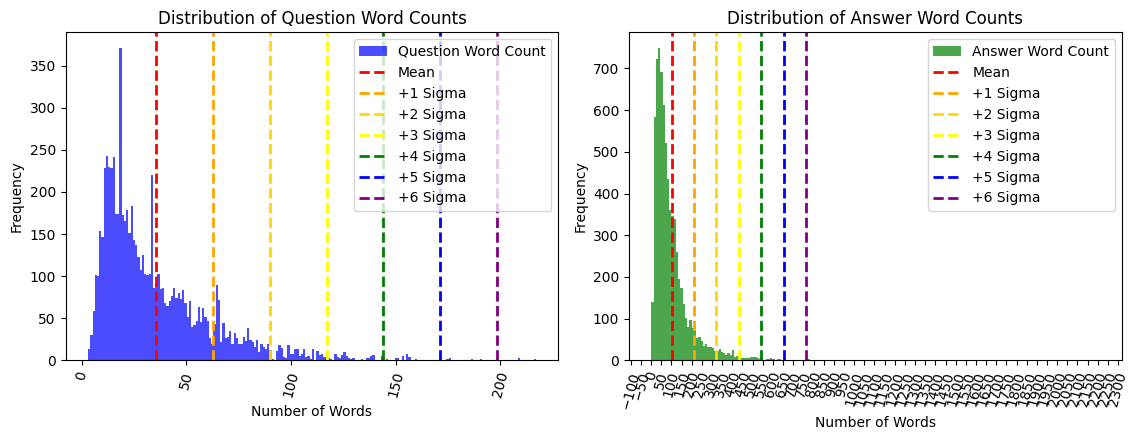

In [8]:
# Function to count words in a list of strings
def count_words(lst):
    return [len(sent.split()) for sent in lst]

# Count the number of words in questions and answers
question_word_counts = count_words(questions)
answer_word_counts = count_words(answers)

# Create a DataFrame for better visualization
count_df = pd.DataFrame({
    'Question Word Count': question_word_counts,
    'Answer Word Count': answer_word_counts
})

# Calculate mean and standard deviation
question_mean = np.mean(question_word_counts)
question_std = np.std(question_word_counts)
answer_mean = np.mean(answer_word_counts)
answer_std = np.std(answer_word_counts)

# Plot the distribution of word counts
fig, axes = plt.subplots(1, 2, figsize=(11.5, 4.5))

# Plot the distribution of question word counts
count_df['Question Word Count'].plot(kind='hist', ax=axes[0], bins=200, alpha=0.7, color='blue')
axes[0].set_title('Distribution of Question Word Counts')
axes[0].set_xlabel('Number of Words')
axes[0].set_ylabel('Frequency')

# Set x-axis ticks to every 50th value
axes[0].xaxis.set_major_locator(mticker.MultipleLocator(50))

# Rotate x-axis labels by 75 degrees
for label in axes[0].get_xticklabels():
    label.set_rotation(75)

# Add mean and sigma lines for questions
axes[0].axvline(question_mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
axes[0].axvline(question_mean + question_std, color='orange', linestyle='dashed', linewidth=2, label='+1 Sigma')
axes[0].axvline(question_mean + 2 * question_std, color='gold', linestyle='dashed', linewidth=2, label='+2 Sigma')
axes[0].axvline(question_mean + 3 * question_std, color='yellow', linestyle='dashed', linewidth=2, label='+3 Sigma')
axes[0].axvline(question_mean + 4 * question_std, color='green', linestyle='dashed', linewidth=2, label='+4 Sigma')
axes[0].axvline(question_mean + 5 * question_std, color='blue', linestyle='dashed', linewidth=2, label='+5 Sigma')
axes[0].axvline(question_mean + 6 * question_std, color='purple', linestyle='dashed', linewidth=2, label='+6 Sigma')
axes[0].legend()

# Plot the distribution of answer word counts
count_df['Answer Word Count'].plot(kind='hist', ax=axes[1], bins=200, alpha=0.7, color='green')
axes[1].set_title('Distribution of Answer Word Counts')
axes[1].set_xlabel('Number of Words')
axes[1].set_ylabel('Frequency')

# Set x-axis ticks to every 50th value
axes[1].xaxis.set_major_locator(mticker.MultipleLocator(50))

# Rotate x-axis labels by 75 degrees
for label in axes[1].get_xticklabels():
    label.set_rotation(75)

# Add mean and sigma lines for answers
axes[1].axvline(answer_mean, color='red', linestyle='dashed', linewidth=2, label='Mean')
axes[1].axvline(answer_mean + answer_std, color='orange', linestyle='dashed', linewidth=2, label='+1 Sigma')
axes[1].axvline(answer_mean + 2 * answer_std, color='gold', linestyle='dashed', linewidth=2, label='+2 Sigma')
axes[1].axvline(answer_mean + 3 * answer_std, color='yellow', linestyle='dashed', linewidth=2, label='+3 Sigma')
axes[1].axvline(answer_mean + 4 * answer_std, color='green', linestyle='dashed', linewidth=2, label='+4 Sigma')
axes[1].axvline(answer_mean + 5 * answer_std, color='blue', linestyle='dashed', linewidth=2, label='+5 Sigma')
axes[1].axvline(answer_mean + 6 * answer_std, color='purple', linestyle='dashed', linewidth=2, label='+6 Sigma')
axes[1].legend()

plt.tight_layout()
plt.show()


In [9]:
# Tokenization questions and answers
questions = [word_tokenize(ques, format='text') for ques in questions]
answers = [word_tokenize(ans, format='text') for ans in answers]

In [ ]:
my_df = pd.DataFrame()
my_df['question'] = questions
my_df['answer'] = answers

In [ ]:
import tensorflow as tf
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

base_model = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(base_model)
model = AutoModelForSeq2SeqLM.from_pretrained(base_model)

tokenizer_config.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/1.20G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## Split Dataset

In [12]:
from datasets import Dataset

# Function to preprocess the data
def preprocess_data(examples):
    inputs = [f"question: {q}" for q in examples['question']]
    targets = [f"{a}" for a in examples['answer']]  # Targets are just the answers

    model_inputs = tokenizer(inputs, max_length=192, truncation=True, padding='max_length')
    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=768, truncation=True, padding='max_length')

    model_inputs["labels"] = labels["input_ids"]  # Labels are the decoder_input_ids
    return model_inputs

# Convert DataFrame to Dataset
dataset = Dataset.from_pandas(my_df)

# Preprocess the dataset
tokenized_dataset = dataset.map(preprocess_data, batched=True)

Map:   0%|          | 0/7339 [00:00<?, ? examples/s]

In [13]:
# Split the dataset into training and validation sets
train_dataset, val_dataset = tokenized_dataset.train_test_split(test_size=0.1, seed=42).values()

# Modeling

## Config

In [14]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [15]:
from transformers import TrainerCallback
from torch.utils.tensorboard import SummaryWriter

class EarlyStoppingCallback(TrainerCallback):
    def __init__(self, patience=5):
        self.patience = patience
        self.best_metric = None
        self.counter = 0

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        if self.best_metric is None or metrics['eval_loss'] < self.best_metric:
            self.best_metric = metrics['eval_loss']
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                control.should_training_stop = True


In [ ]:
# Save model  and tokenizer to "vi-medical-transformer-fintune"
os.makedirs("models", exist_ok=True)
out_model_name = "vi-medical-t5-finetune-qa"
out_model_path = f"models/{out_model_name}"

In [27]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir=out_model_path,
    evaluation_strategy='epoch',
    learning_rate=1e-4,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=26,
    weight_decay=0.01,
    save_total_limit=1,
    load_best_model_at_end=True,  # Load the best model at the end of training
    metric_for_best_model='eval_loss',  # Use evaluation loss as the metric
    greater_is_better=False,  # Lower evaluation loss is better
    save_strategy='epoch'  # Ensure save strategy matches evaluation strategy
)

early_stopping_callback = EarlyStoppingCallback(patience=10)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[early_stopping_callback]
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


## Training

In [28]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.473200,0.395538
2,0.406000,0.382062
3,0.398900,0.377744
4,0.375000,0.367524
5,0.405700,0.360998
6,0.389800,0.355099
7,0.393000,0.349508
8,0.401700,0.345235
9,0.360900,0.343793
10,0.343600,0.338723


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=85878, training_loss=0.3532296384634921, metrics={'train_runtime': 29708.0106, 'train_samples_per_second': 5.781, 'train_steps_per_second': 2.891, 'total_flos': 3.40508191555584e+16, 'train_loss': 0.3532296384634921, 'epoch': 26.0})

## Model Evaluation

In [29]:
# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation results: {eval_results}")

Evaluation results: {'eval_loss': 0.3224388360977173, 'eval_runtime': 35.113, 'eval_samples_per_second': 20.904, 'eval_steps_per_second': 10.452, 'epoch': 26.0}


## Save Model

In [30]:
model.save_pretrained(out_model_path)
tokenizer.save_pretrained(out_model_path)

('models/vi-medical-t5-finetune/tokenizer_config.json',
 'models/vi-medical-t5-finetune/special_tokens_map.json',
 'models/vi-medical-t5-finetune/spiece.model',
 'models/vi-medical-t5-finetune/added_tokens.json',
 'models/vi-medical-t5-finetune/tokenizer.json')

# Inference

In [31]:
import re
import torch
# from transformers import T5Tokenizer, T5ForConditionalGeneration
# T5Tokenizer, T5ForConditionalGeneration
def load_model_and_tokenizer(output_dir):
    # Load the trained tokenizer
    tokenizer = AutoTokenizer.from_pretrained(output_dir)

    # Load the trained model
    model = AutoModelForSeq2SeqLM.from_pretrained(output_dir)

    # Move the model to the GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    return tokenizer, model, device

def generate_text(tokenizer, model, device, prompt, max_length=100,
                  num_return_sequences=1, top_p=0.95, temperature=0.7):
    # Tokenize the input prompt
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)

    # Generate text
    output = model.generate(
        input_ids,
        max_length=max_length,
        num_return_sequences=num_return_sequences,
        no_repeat_ngram_size=2,
        top_k=50,
        top_p=top_p,
        temperature=temperature,
        do_sample=True
    )

    # Convert the generated text back to a string
    generated_text = [tokenizer.decode(ids, skip_special_tokens=True) for ids in output]

    return generated_text

# Load the trained model and tokenizer
output_dir = "models/vi-medical-t5-finetune-qa"
tokenizer, model, device = load_model_and_tokenizer(output_dir)

In [32]:
# Define the prompt for text generation
prompt = "bị muỗi đốt có mắc covid-19 không?"
# Generate text
generated_text = generate_text(tokenizer, model, device, prompt,
                               max_length=768,
                               num_return_sequences=1, top_p=0.95, temperature=0.7)

# Print the generated text
print("Generated Text:\n")
result = generated_text[0].replace("_", " ").replace(" ,", ",").replace(" .", ".").replace(" -", "\n-")
print(result)

Generated Text:

Chưa có chắc chắn nào cho thấy Covid-19 được phát hiện từ người bị muỗi đốt. Tuy nhiên, nếu bạn bệnh muổi ốm và muốn đổt thì sẽ không xảy ra các triệu chứng COVID-19 gây covid-19


In [33]:
# Define the prompt for text generation
prompt = "covid-19 là gì?"
# Generate text
generated_text = generate_text(tokenizer, model, device, prompt,
                               max_length=768,
                               num_return_sequences=1, top_p=0.95, temperature=0.7)

# Print the generated text
print("Generated Text:\n")
result = generated_text[0].replace("_", " ").replace(" ,", ",").replace(" .", ".").replace(" -", "\n-")
print(result)

Generated Text:

Để chắc chắn, hiện nay chưa có vấn đề nào cho thấy covid-19 thể gây bệnh nặng. Tuy nhiên trong các nghiên cứu hơn từ một số trường hợp xảy ra là sự lây lan của COVID-19 ở mức ộ là chỉ được đánh giá lần đầu tiên như sau : Đau nhức và ớn lạnh ; đau bụng dữ dội
- rối loạn ý nghĩa / tụt huyết áp ≥ 60 % Người mắc bất kỳ tác dụng khác nhau vì cái mới gần đây đã ổn lên ) Trong ít trọng mọi lúc bên ngoài nên vẫn có thai ? Các loại coronavirus đều có dạng cảm cúm Những người Trung Quốc năm 2003   2019 ngày tháng 11/2020 nói chung chẳng may nhiễm COVID--19 khác ( WHO ] tên vaccine Sputnik V công bố cũng không có cơ quan yếu mắc âm gồm cách uống chín chung chịu cung ứng thông tin ăn món ức đề xuất hoang mang i khuẩn hoặc áo rượu mũi hoạt hại cấp phát nguồn virus kém Xem giám sát tòa cộng Đồng Nó ảnh ưởng đến hiệu quả chính mình áp tâm để tìm nguyên tác phòng vệ cụ theo 


In [34]:
# Define the prompt for text generation
prompt = "ai có nguy cơ mắc covid-19 nhiều nhất?"
# Generate text
generated_text = generate_text(tokenizer, model, device, prompt,
                               max_length=768,
                               num_return_sequences=1, top_p=0.95, temperature=0.7)

# Print the generated text
print("Generated Text:\n")
result = generated_text[0].replace("_", " ").replace(" ,", ",").replace(" .", ".").replace(" -", "\n-")
print(result)

Generated Text:

Người có nguy cơ mắc COVID-19 cao nhất có thể mới có triệu cuộc nhiễm COVID 19 từ các trung tâm y tế. Những người có được một số trẻ em có mức độ ít gặp phải những trên địa bàn, thành phố đã có bệnh lý rất hiếm như sốc phản vệ và lớn trong mọi người vì liệu về hệ miễn dịch ở bất kỳ tác nhân nào ? Các trường hợp bị nhiêm trọng bao gồm cả Trung Quốc ;
- Trong giai pháp xét nghiệm SARS-CoV-2 : Đối xử ứng dụng PPE / PCR nhanh chóng lên đến 89 % người trở nên ≥ 12 tuổi ≤ 65 tuần ) Tuy nuôi kém hơn nhau hãy thực hành thăm dò kết quả của cơ quan kinh doanh vaccine Covid-19 ngày nay công tác phòng nhiễu năm 2007 áp ứu 5 tháng sau khi ăn uống uắt khoa mẹ Hà Nội Tiến Định Giám sát Sở Y Tế Thế giới ( WHO ] Công dân Mỹ ( Bộ Y Tế Bản Thành Phố ” Ứng Viện Vệ Sinh Hồi Sức Ăn Hòa Huyết Thanh Lãnh TAND TP.HCM Ưu Chỉ Mục Quân Anh Âu Đồng Giới CDC Ông Tạo Tổ Chức Yên Bục Advisory Group = AKI ARV ' Nicholas Louis !
